# Load package and plot data

In [1]:
import os
import sys
import mmap

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy as sp
import scipy.io as sio
import scipy.stats as ss

from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.decomposition import NMF
from sklearn import linear_model

%load_ext autoreload
%autoreload 2

In [2]:
# Example movie extracted from https://github.com/simonsfoundation/CaImAn
data_dir = "/Users/zhd/Desktop/Research/Project/IARPA data/data/"

In [3]:
out_dir ='/Users/zhd/Desktop/Research/Project/IARPA data/first_try/'

In [4]:
Yd_data =  np.load(data_dir + "baylor_3D_dx4.npz")#"Yd_baylor_outs4dx.npz")

In [5]:
Y_orig_data =  np.load(data_dir + "baylor_3D_dinfo.npz")

In [6]:
dims= Yd_data["W1_four"].shape

In [7]:
sn_= Y_orig_data["nl1"].reshape((dims[0],dims[1],1),order="F")
mean_= Y_orig_data["mean_px1"].reshape((dims[0],dims[1],1),order="F")

In [8]:
Ydx = Yd_data["W1_four"]*sn_ + mean_;

In [9]:
Y_origx = Y_orig_data["W1"].reshape(dims,order="F")*sn_ + mean_;

In [10]:
sn_= Y_orig_data["nl2"].reshape((dims[0],dims[1],1),order="F")
mean_= Y_orig_data["mean_px2"].reshape((dims[0],dims[1],1),order="F")

In [11]:
Ydy = Yd_data["W2_four"]*sn_ + mean_;

In [12]:
Y_origy = Y_orig_data["W2"].reshape(dims,order="F")*sn_ + mean_;

In [13]:
sn_= Y_orig_data["nl3"].reshape((dims[0],dims[1],1),order="F")
mean_= Y_orig_data["mean_px3"].reshape((dims[0],dims[1],1),order="F")

In [14]:
Ydz = Yd_data["W3_four"]*sn_ + mean_;

In [15]:
Y_origz = Y_orig_data["W3"].reshape(dims,order="F")*sn_ + mean_;

In [16]:
Ytx = np.memmap(data_dir+"Ytx.mmap", dtype='float32', mode='r',shape=dims,order='F');
Yty = np.memmap(data_dir+"Yty.mmap", dtype='float32', mode='r',shape=dims,order='F');
Ytz = np.memmap(data_dir+"Ytz.mmap", dtype='float32', mode='r',shape=dims,order='F');

In [17]:
################## code to construct Yt (Yt can also be directly load as above) ##########################
Ytx = np.zeros(dims);
Yty = np.zeros(dims);
Ytz = np.zeros(dims);
ii=0;
for array in [Ydx, Ydy, Ydz]:
    Yd_median = np.median(array, axis=2, keepdims=True)
    Yd_mad = np.median(abs(array - Yd_median), axis=2, keepdims=True)
    th = 2;
    if ii==0:
        for i in range(dims[2]):
            Ytx[:,:,i] = np.clip(array[:,:,i], a_min = (Yd_median + th*Yd_mad)[:,:,0], a_max = None) - (Yd_median + th*Yd_mad)[:,:,0]
    if ii==1:
        for i in range(dims[2]):
            Yty[:,:,i] = np.clip(array[:,:,i], a_min = (Yd_median + th*Yd_mad)[:,:,0], a_max = None) - (Yd_median + th*Yd_mad)[:,:,0]
    if ii==2:
        for i in range(dims[2]):
            Ytz[:,:,i] = np.clip(array[:,:,i], a_min = (Yd_median + th*Yd_mad)[:,:,0], a_max = None) - (Yd_median + th*Yd_mad)[:,:,0]
    ii=ii+1;    

In [17]:
T = dims[2]

# correlation analysis - find superpixels

In [18]:
Yt = np.concatenate([Ytx.reshape(np.prod(dims[:2]),dims[2],order="F"),
                     Yty.reshape(np.prod(dims[:2]),dims[2],order="F"),
                     Ytz.reshape(np.prod(dims[:2]),dims[2],order="F")], axis=0).reshape(dims[0],dims[1],3,dims[2],order="F")

In [19]:
cut_off_point = 0.97; ############# correlation threshold #############
num_plane = 3;
length_cut = 10*num_plane; ################## size threshold ##################
ref_mat = np.arange(num_plane*np.prod(dims[:2])).reshape(dims[0],dims[1],num_plane, order='F')

In [20]:
w_mov = (Yt.transpose(3,0,1,2) - np.mean(Yt, axis=3)) / np.std(Yt, axis=3);
w_mov[np.isnan(w_mov)] = 0;

rho_v = np.mean(np.multiply(w_mov[:, :-1, :, :], w_mov[:, 1:, :, :]), axis=0)
rho_h = np.mean(np.multiply(w_mov[:, :, :-1, :], w_mov[:, :, 1:, :]), axis=0)

eight_neighbours = True;

if eight_neighbours:
    rho_l = np.mean(np.multiply(w_mov[:, 1:, :-1, :], w_mov[:, :-1, 1:, :]), axis=0)
    rho_r = np.mean(np.multiply(w_mov[:, :-1, :-1, :], w_mov[:, 1:, 1:, :]), axis=0)
    
rho_u = np.mean(np.multiply(w_mov[:, :, :, :-1], w_mov[:, :, :, 1:]), axis=0)

rho_v = np.concatenate([rho_v, np.zeros([1, rho_v.shape[1],num_plane])], axis=0)
rho_h = np.concatenate([rho_h, np.zeros([rho_h.shape[0],1,num_plane])], axis=1)
if eight_neighbours:
    rho_r = np.concatenate([rho_r, np.zeros([rho_r.shape[0],1,num_plane])], axis=1)
    rho_r = np.concatenate([rho_r, np.zeros([1, rho_r.shape[1],num_plane])], axis=0)
    rho_l = np.concatenate([np.zeros([rho_l.shape[0],1,num_plane]), rho_l], axis=1)
    rho_l = np.concatenate([rho_l, np.zeros([1, rho_l.shape[1],num_plane])], axis=0)
rho_u = np.concatenate([rho_u, np.zeros([rho_u.shape[0], rho_u.shape[1],1])], axis=2)

In [21]:
temp_v = np.where(rho_v > cut_off_point);
A_v = ref_mat[temp_v];
B_v = ref_mat[(temp_v[0] + 1, temp_v[1], temp_v[2])]

temp_h = np.where(rho_h > cut_off_point);
A_h = ref_mat[temp_h];
B_h = ref_mat[(temp_h[0], temp_h[1] + 1, temp_h[2])]

temp_u = np.where(rho_u > cut_off_point);
A_u = ref_mat[temp_u];
B_u = ref_mat[(temp_u[0], temp_u[1], temp_u[2]+1)]

if eight_neighbours:
    temp_l = np.where(rho_l > cut_off_point);
    A_l = ref_mat[temp_l];
    B_l = ref_mat[(temp_l[0] + 1, temp_l[1] - 1, temp_l[2])]
    
    temp_r = np.where(rho_r > cut_off_point);
    A_r = ref_mat[temp_r];
    B_r = ref_mat[(temp_r[0] + 1, temp_r[1] + 1, temp_r[2])]

    A = np.concatenate([A_v,A_h,A_l,A_r,A_u])
    B = np.concatenate([B_v,B_h,B_l,B_r,B_u])
else:
    A = np.concatenate([A_v,A_h,A_u])
    B = np.concatenate([B_v,B_h,B_u])    

In [22]:
G = nx.Graph()
G.add_edges_from(list(zip(A, B)))
comps=list(nx.connected_components(G))

connect_mat=np.zeros(3*np.prod(dims[:2]));
idx=1;
for comp in comps:
    if(len(comp) > length_cut):
        idx = idx+1;

permute_col = np.random.permutation(idx)+1;

ii=0;
for comp in comps:
    if(len(comp) > length_cut):
        connect_mat[list(comp)] = permute_col[ii];
        ii = ii+1;
connect_mat_1 = connect_mat.reshape(dims[0],dims[1],num_plane, order='F')        

In [23]:
fig = plt.figure(figsize=(24,8))
for ii in range(3):
    plt.subplot(1,3,ii+1);
    plt.imshow(connect_mat_1[:,:,ii],cmap='jet')
    plt.title("Ssupervoxels projection in plane " + str(ii+1),fontsize=15,fontweight="bold");
fig.tight_layout()
#fig.savefig(out_dir + "superpixels in three planes.pdf")

# rank-1 svd - find temporal trace for superpixels

In [ ]:
Yt_r= Yt.reshape(num_plane*np.prod(dims[:2]),T,order = "F");
ii=0;
maxiter=5;
U_mat = np.zeros([num_plane*np.prod(dims[:2]),idx-1]);
B_mat = np.zeros([num_plane*np.prod(dims[:2]),idx-1]);
V_mat = np.zeros([T,idx-1]);

for comp in comps:
    if(len(comp) > length_cut):
        y_temp = Yt_r[list(comp),:];
        unique_t = np.unique(np.where(y_temp > 0)[1]);
        b = np.median(y_temp, axis=1, keepdims=True);
        _, _, c = np.linalg.svd(y_temp - b, full_matrices=False)
        c = c[0,:];
        if (c[np.where(abs(c)==abs(c).max())[0]] < 0):
            c=-1*c;
        a = np.zeros(len(comp));
        
        for jj in range(maxiter):
            for xx in range(len(comp)):
                    pos = np.where(y_temp[xx,:] > 0);
                    reg = linear_model.LassoLars(alpha=0, fit_intercept=False, positive=True);
                    temp = reg.fit(np.vstack((c[pos],np.ones(len(pos[0])))).T,y_temp[xx, pos].T);
                    a[xx]=temp.coef_[0];
                    b[xx,0]=temp.coef_[1];
            for tt in range(len(unique_t)):
                    pos = np.where(y_temp[:,unique_t[tt]] > 0);
                    reg = linear_model.LassoLars(alpha=0, fit_intercept=False, positive=True);
                    temp = reg.fit(a[pos].reshape(len(pos[0]),1),(y_temp[pos, unique_t[tt]] - b[pos,0]).T);     
                    c[unique_t[tt]]=temp.coef_[0];
        
        U_mat[list(comp),ii] = a;
        B_mat[list(comp),ii] = b[:,0];
        V_mat[:,ii] = c;
        ii = ii+1;

In [28]:
Ys_r = np.matmul(U_mat, V_mat.T) + B_mat.sum(axis=1).reshape(num_plane*np.prod(dims[:2]),1)
Ys = Ys_r.reshape(dims[0],dims[1],num_plane,T,order="F");

In [29]:
def vcorrcoef(X,y):
    Xm = np.reshape(np.mean(X,axis=1),(X.shape[0],1))
    ym = np.mean(y)
    r_num = np.sum((X-Xm)*(y-ym),axis=1)
    r_den = np.sqrt(np.sum((X-Xm)**2,axis=1)*np.sum((y-ym)**2))
    r = r_num/r_den
    return r

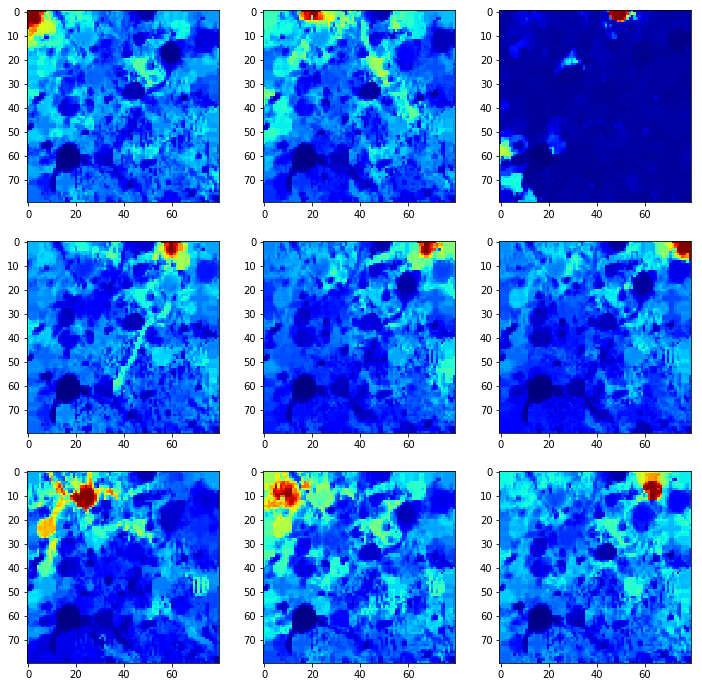

In [30]:
################ visualize corr_i = corr(Yt(x,t),c_i(t)) ########################
fig = plt.figure(figsize=(12,12));
for ii in range(9):
    corr_img = vcorrcoef(Yt_r, V_mat[:,ii]).reshape(dims[0],dims[1],num_plane,order="F");
    plt.subplot(3,3,ii+1)
    plt.imshow(corr_img[:,:,0],cmap="jet");

# SPA - find pure superpixel

In [35]:
################### specify a small region to find out all the pure superpixels in this region ##################
up=0;
down=79;
left=0;
right=79;

In [32]:
def find_superpixel_in_range(x_range,y_range, connect_mat):
    return np.sort(np.unique(connect_mat[x_range[0]:(x_range[1]+1), y_range[0]:(y_range[1]+1), :]))[1:]

In [34]:
unique_pix = find_superpixel_in_range([up,down],[left,right], connect_mat_1);
M = np.zeros([T, len(unique_pix)]);
for ii in range(len(unique_pix)):
    M[:,ii] =  V_mat[:,int(np.where(permute_col==unique_pix[ii])[0])];

In [39]:
aa = np.memmap(out_dir + "M.mmap", dtype='float64', mode='w+',shape=(T, len(unique_pix)),order='F');
aa[:,:]=M[:,:];

In [4]:
###################### run SPA in matlab and load the results ############################
pure_pixels = sio.loadmat(out_dir + "spa_rlt8.mat")['rlt']

In [5]:
print(np.sort(pure_pixels[0,:]))

[ 1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 50 51 53 54
 55 57 58 59 60]


# visualize pure superpixels

In [42]:
####################### order superpixel according to brightness ############################
pure_pix = np.zeros(len(pure_pixels[0]));
brightness = np.zeros(len(pure_pixels[0]));
for ii in range(len(pure_pixels[0])):
    pure_pix[ii] = unique_pix[pure_pixels[0,ii]-1];
    v_max = V_mat[:,np.where(permute_col==unique_pix[pure_pixels[0,ii]-1])[0][0]].max();
    u_max = U_mat[:,np.where(permute_col==unique_pix[pure_pixels[0,ii]-1])[0][0]].max();
    brightness[ii] = u_max * v_max;

In [43]:
brightness_rank = len(pure_pix) - ss.rankdata(brightness,method="ordinal")+1

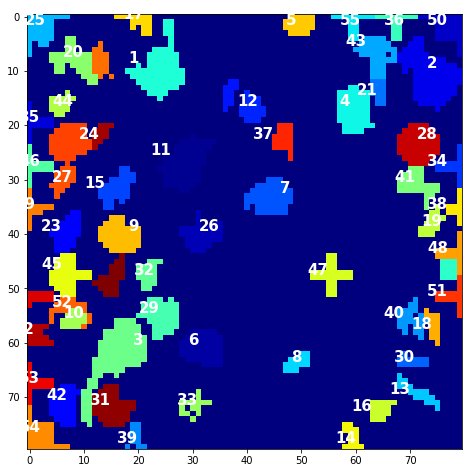

In [45]:
fig = plt.figure(figsize=(8,8));
ax = fig.add_subplot(111)
plt.imshow(connect_mat_1[up:(down+1),left:(right+1),0],cmap="jet")

for ii in range(len(pure_pix)):
    pos = np.where(connect_mat_1[:,:,0] == pure_pix[ii]);
    pos0 = pos[0] - up;
    pos1 = pos[1] - left;
    ax.text((pos1)[np.array(len(pos1)/3,dtype=int)], (pos0)[np.array(len(pos0)/3,dtype=int)+5], f"{brightness_rank[ii]}",
        verticalalignment='bottom', horizontalalignment='right',color='white', fontsize=15, fontweight="bold")
#fig.savefig(out_dir + "labeled_fig.pdf")

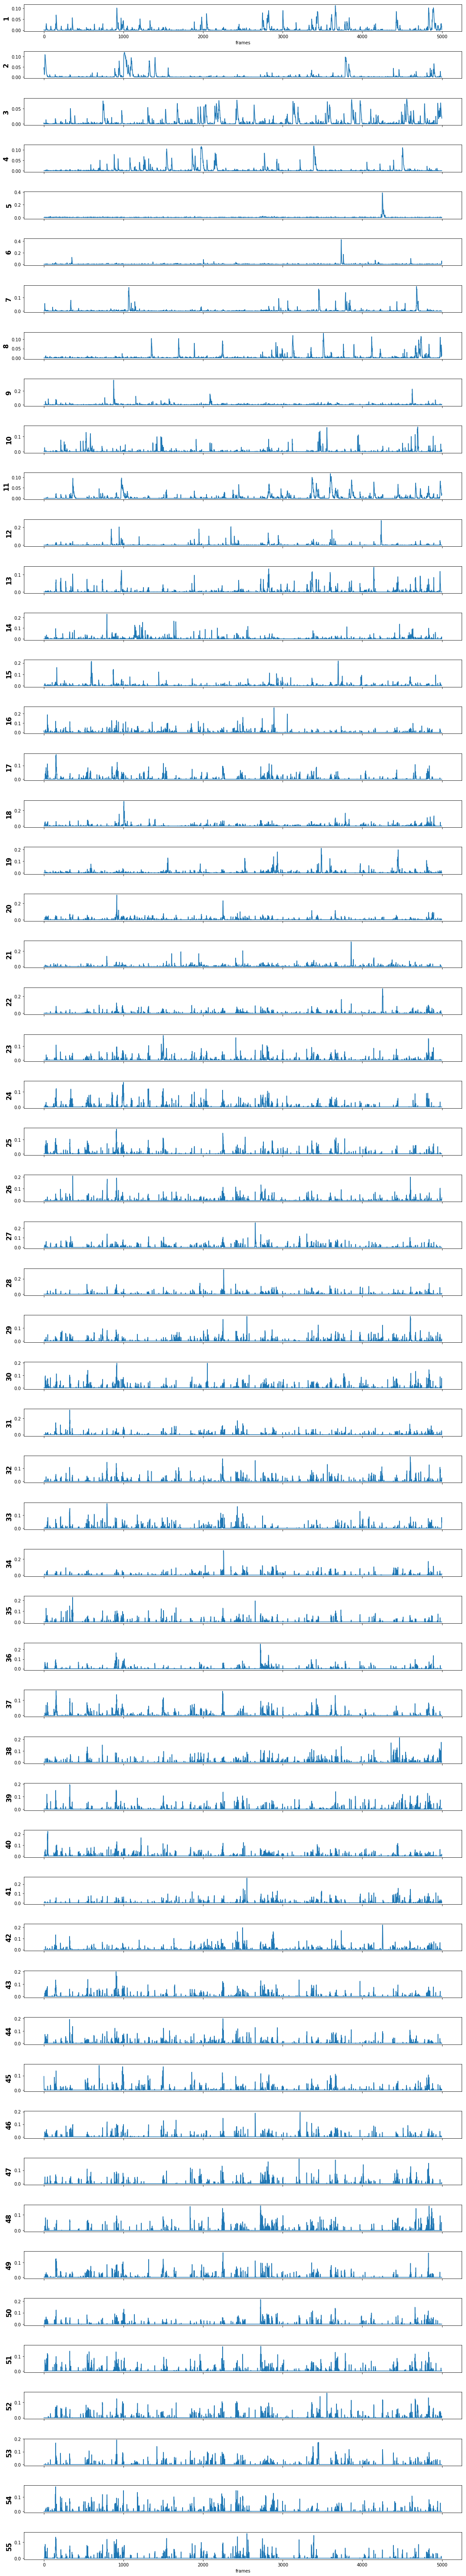

In [46]:
num = len(pure_pix);
fig = plt.figure(figsize=(15,1.5*num))
#fig = plt.figure(figsize=(15,1.5*8))
for ii in range(num):
    pos = np.where(permute_col==pure_pix[np.where(brightness_rank == ii+1)[0]])[0][0];
    plt.subplot(num,1, ii+1);
    plt.plot(V_mat[:,pos]);
    plt.ylabel(f"{ii+1}",fontweight="bold",fontsize=15)
    if (ii > 0 and ii < num-1):
        plt.tick_params(axis='x',which='both',labelbottom='off')
    else:
        plt.xlabel("frames");
fig.tight_layout()
#fig.savefig(out_dir + "pure_superpixel_temp_trace_full.pdf")

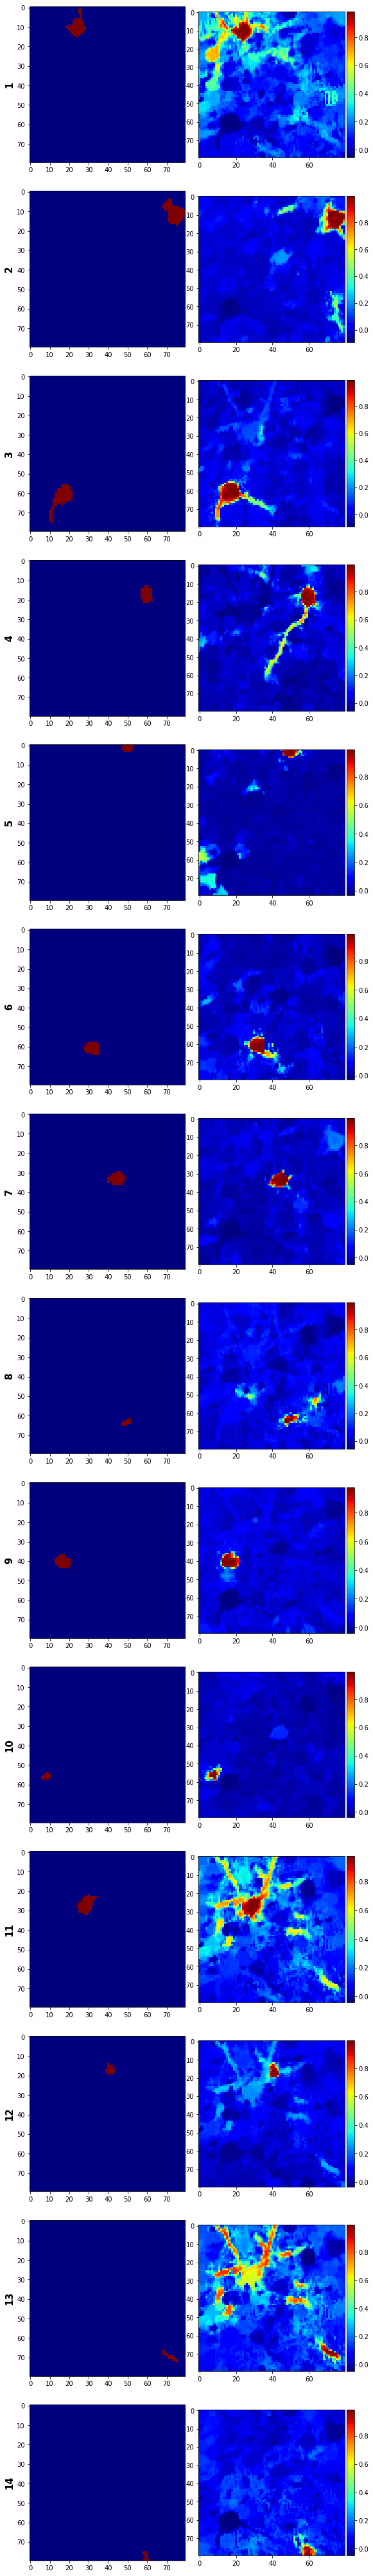

In [47]:
num = 14;#len(pure_pix);
fig = plt.figure(figsize=(8,num*4));
for ii in range(num):
    plt.subplot(num,2,2*ii+1);
    plt.imshow(connect_mat_1[:,:,0] == pure_pix[np.where(brightness_rank == ii+1)[0]],cmap="jet");
    plt.ylabel(f"{ii+1}",fontweight="bold",fontsize=15);
    #plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    corr_img = vcorrcoef(Yt_r, V_mat[:,np.where(permute_col==pure_pix[np.where(brightness_rank == ii+1)[0]])[0][0]]).reshape(dims[0],dims[1],3,order="F");
    ax=plt.subplot(num,2,2*(ii+1));
    fig2=ax.imshow(corr_img[:,:,0],cmap="jet");
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(fig2,cax=cax, orientation='vertical')
fig.tight_layout();
#fig.savefig(out_dir + "superpixel_corr_full.pdf")